In [1]:
%matplotlib inline
%load_ext autoreload

<strong>Dependencies</strong>: MeshPy, PyVTK, trimesh

<strong>Useful links</strong>:
 - TetGen : http://wias-berlin.de/software/tetgen/1.5/doc/manual/manual006.html
 - MeshPy : https://documen.tician.de/meshpy/tri-tet.html#meshpy.tet.MeshInfo.adjacent_elements
 - SRF BluePrint : http://i.cs.hku.hk/~wenping/allhex.pdf
 
 - http://math.stackexchange.com/questions/225246/explanation-about-frames-as-distinct-from-a-co-ordinate-system

## Generate Tetrahedral Mesh

In [2]:
import meshpy
from meshpy.tet import MeshInfo, build
import numpy as np
import trimesh

tri_mesh = trimesh.load_mesh('../data/cylinder.stl')

# Define MeshPy options!
opt = meshpy.tet.Options(switches='pq', edgesout=True, facesout=True, neighout=True)

mesh_info = MeshInfo()
mesh_info.set_points(tri_mesh.vertices)
# Convert face data from np.int64 to int...
faces = [list(map(lambda x: int(x), i)) for i in tri_mesh.faces]
mesh_info.set_facets(faces)
tet_mesh = build(mesh_info, opt, max_volume=10)

# Output tetrahedral mesh
tet_mesh.write_vtk("../data/test.vtk")

## Compute surface curvature

#### Some useful information

 - Internal tetrahedrons have 4 neighbors (one on each face) - the neighbor 4-tuple is the indices of the neighboring tets.

 - The first neighbor of tetrahedron 'i' is oppposite to the first corner of tetrahedron 'i', and so on.

 - An index of -1 indicates there is no neighbor.

In [3]:
def is_facing(triangles, normals, reference):
    '''
    When deciding if a polygon is facing the camera, you need
    only calculate the dot product of the normal vector of
    that polygon, with a vector from the reference point to one
    of the polygon's vertices.

    triangles: vertices of triangles, (n,3,3)
    returns:   boolean, (n,1)
    '''
    return [not (np.dot(normals[i], reference - t[0])) < 0.0 for i, t in enumerate(triangles)]

In [268]:
surface_faces = []
for i, tet in enumerate(tet_mesh.elements):
    
    neighbors = np.array(tet_mesh.neighbors[i])
    # Try to get the vertex indices of boundary face.
    # TODO(aidan) This only looks at the first boundary face, consider case where a tet has multiple...
    if -1 in neighbors:
        opposite_to_surface = np.where(neighbors == -1)[0]
        # Remove from the tetrahedron list of vertices to create a surface face
        if len(opposite_to_surface) == 1:
            indices = list(range(4))
            indices.remove(opposite_to_surface[0])
            if 1 not in indices or 3 not in indices:
                indices = list(reversed(indices))
            face = [tet[i] for i in indices]
            surface_faces.append(face)
        
        # Create two surfaces that exclusively include a vertex opposite to surface
        elif len(opposite_to_surface) == 2:
            indices = list(range(4))
            indices = [i for i in indices if i not in opposite_to_surface]
            # Face one
            face_one_ind = indices + [opposite_to_surface[0]]
            if 1 not in face_one_ind or 3 not in face_one_ind:
                face_one_ind = list(reversed(face_one_ind))
            # Face two
            face_two_ind = indices + [opposite_to_surface[1]]
            if 1 not in face_two_ind or 3 not in face_two_ind:
                face_two_ind = list(reversed(face_two_ind))
            # Get proper indices
            face_one = [tet[i] for i in face_one_ind]
            face_two = [tet[i] for i in face_two_ind]
            # Add to structure
            surface_faces.append(face_one)
            surface_faces.append(face_two)
            
        else:
            pass
            #error


### Compute the normal of each surface triangle

In [269]:
from numpy import vstack

# Compute normal
def compute_normal(face):
    return np.cross(np.array(tet_mesh.points[face[0]]) - np.array(tet_mesh.points[face[1]]),
                    np.array(tet_mesh.points[face[2]]) - np.array(tet_mesh.points[face[1]]))

def compute_avg(face):
    return (np.array(tet_mesh.points[face[0]])
          + np.array(tet_mesh.points[face[1]])
          + np.array(tet_mesh.points[face[2]])) / 3

face_normals = [compute_normal(face) for face in surface_faces]
face_center = [compute_avg(face) for face in surface_faces]

# Correct normal
center = vstack(tet_mesh.points).mean()
triangles = [np.array([tet_mesh.points[f[0]], tet_mesh.points[f[1]], tet_mesh.points[f[2]]]) for f in surface_faces]

facing = is_facing(triangles, face_normals, center)
for i, verdict in enumerate(facing):
    if verdict:
        face_normals[i] = -face_normals[i]


#### Visualize normals

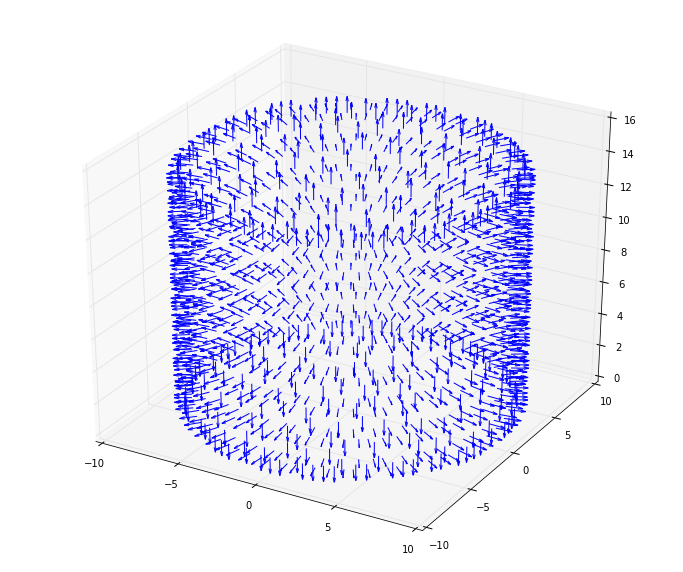

In [270]:
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

for i, f in enumerate(surface_faces):
    ax.quiver(face_center[i][0], face_center[i][1], face_center[i][2], face_normals[i][0], face_normals[i][1], face_normals[i][2])

plt.show()

### Compute the face neighbours of each surface vertices

In [271]:
# Get neighbours
dedup_vertices = set(list(np.concatenate(surface_faces)))
surrounding_faces = {}
for i, v in enumerate(dedup_vertices):
    surrounding_faces[v] = list(filter(lambda f: f[1][0] == v or f[1][1] == v or f[1][2] == v, zip(range(0, len(surface_faces)), surface_faces)))

### Compute the normal of each surface vertices

In [381]:
from numpy import vstack

def get_vertex_norm(face):
    return vstack([face_normals[ind] for ind, f in faces]).mean(axis=0)

v_norms = {}
for i, v in enumerate(dedup_vertices):
    faces = surrounding_faces[v]
    v_norms[v] = get_vertex_norm(faces)

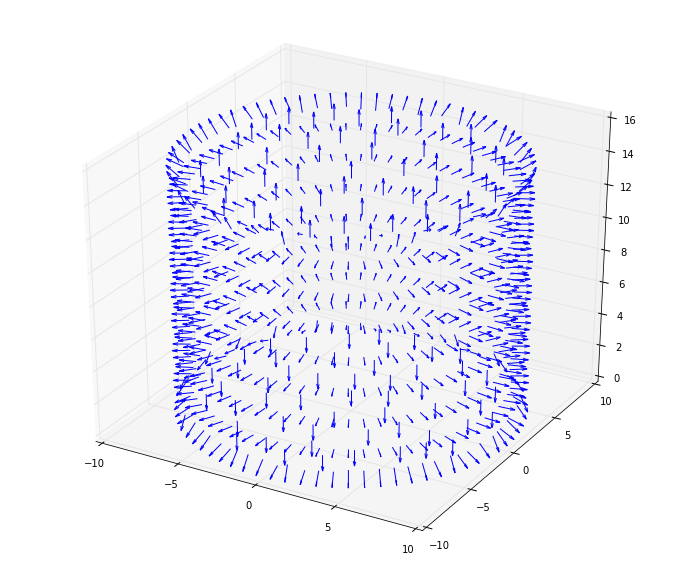

In [382]:
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

for i in dedup_vertices:
    i = int(i)
    ax.quiver(tet_mesh.points[i][0], tet_mesh.points[i][1], tet_mesh.points[i][2], v_norms[i][0], v_norms[i][1], v_norms[i][2])

plt.show()

### Compute curvature

#### Approximate through edge curvature

In [28]:
def gram_schmidt_process(A):
    """Perform QR decomposition of matrix A using Gram-Schmidt process."""
    (num_rows, num_cols) = np.shape(A)

    # Initialize empty orthogonal matrix Q.
    Q = np.empty([num_rows, num_rows])
    cnt = 0

    # Compute orthogonal matrix Q.
    for a in A.T:
        u = np.copy(a)
        for i in range(0, cnt):
            proj = np.dot(np.dot(Q[:, i].T, a), Q[:, i])
            u -= proj

        e = u / np.linalg.norm(u)
        Q[:, cnt] = e

        cnt += 1  # Increase columns counter.

    # Compute upper triangular matrix R.
    R = np.dot(Q.T, A)

    return (Q, R)

In [29]:
from math import copysign, hypot


def givens_rotation(A):
    """Perform QR decomposition of matrix A using Givens rotation."""
    (num_rows, num_cols) = np.shape(A)
    # Initialize orthogonal matrix Q and upper triangular matrix R.
    Q = np.identity(num_rows)
    R = np.copy(A)
    # Iterate over lower triangular matrix.
    (rows, cols) = np.tril_indices(num_rows, -1, num_cols)
    for (row, col) in zip(rows, cols):
        # Compute Givens rotation matrix and
        # zero-out lower triangular matrix entries.
        if R[row, col] != 0:
            (c, s) = _givens_rotation_matrix_entries(R[col, col], R[row, col])
            G = np.identity(num_rows)
            G[[col, row], [col, row]] = c
            G[row, col] = s
            G[col, row] = -s
            R = np.dot(G, R)
            Q = np.dot(Q, G.T)
    return (Q, R)

def _givens_rotation_matrix_entries(a, b):
    """Compute matrix entries for Givens rotation."""
    r = hypot(a, b)
    c = a/r
    s = -b/r
    return (c, s)

In [396]:
from numpy import linalg, transpose, dot, cross, multiply
from numpy.linalg import eig, norm
from source.matrix import Matrix

def length(v):
    return linalg.norm(v)

def get_vertices_from_faces(v):
    ring = list(set(np.concatenate([vert for ind, vert in surrounding_faces[v]])))
    ring.remove(v)
    return ring

max_curv = []
min_curv = []

for vi, v in enumerate(list(dedup_vertices)):
    v = int(v)
    position = np.array(tet_mesh.points[v])
    # Vertex normal as a matrix
    n0 = np.array(v_norms[v]) / length(v_norms[v])
    Nvi = Matrix([[n0[0]], [n0[1]], [n0[2]]])

    # Unsorted ring
    ring = get_vertices_from_faces(v)
    
    # Calculate face weightings, wij
    n = len(ring)
    wij = np.zeros((n,))
    for j in range(n):
        vec0 = tet_mesh.points[int(ring[(j+(n-1))%n])] - position
        vec1 = tet_mesh.points[int(ring[j])] - position
        vec2 = tet_mesh.points[int(ring[(j+1)%n])] - position
        # Assumes closed manifold
        # TODO: handle boundaries
        wij[j] = 0.5 * (length(cross(vec0, vec1)) + length(cross(vec1, vec2)))

    # Sum
    wijSum = wij.sum()
    
    """
    Princeton curvature
    
    # Calculate Mvi
    I = Matrix.identity(3)
    Mvi = Matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    curvature = np.zeros((len(ring),))
    Mvi = np.zeros((3, 3))

    for i, j in enumerate(ring):
        n1 = np.array(v_norms[j])
        vec = np.array(position) - tet_mesh.points[int(j)]
        # edgeAsMatrix = Matrix([vec[0], vec[1], vec[2]])
        curvature[i] = dot((n0 - n1), vec) / (length(vec) ** 2)
        Mvi += curvature[i] * transpose(np.matrix(vec)) * vec
    """
    
    # Calculate Mvi
    I = Matrix.identity(3)
    Mvi = Matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    for i, j in enumerate(ring):
        vec = tet_mesh.points[int(j)] - position
        edgeAsMatrix = Matrix([[vec[0]], [vec[1]], [vec[2]]])
        Tij = (I - (Nvi * Nvi.transpose())) * edgeAsMatrix
        Tij *= (1 / Tij.getFrobeniusNorm())
        kij = (Nvi.transpose() * 2 * edgeAsMatrix).getEntry(0, 0) / (length(vec) ** 2)
        Mvi += Tij.multiply(Tij.transpose()).scalarMultiply((wij[i] / wijSum) * kij)
    
    # Get eigenvalues and eigenvectors for Mvi
    # maxc, minc = givens_rotation(Mvi._array)
    evals, evecs = eig(Mvi._array)
    
    # If zero-matrix 
    """
    if (np.array(evecs) == np.zeros((3, 3))).all():
        max_curv.append(np.zeros((3,)))
        min_curv.append(np.zeros((3,)))
        continue
    """
    
    evecs = [np.array((evecs[0,y], evecs[1,y], evecs[2,y])) for y in range(3)]
    for e in evecs:
        denom = norm(e)
        if denom != 0:
            e /= denom
    evecs = [evecs[y] * evals[y] for y in range(3)]
    sortv = list(zip([abs(i) for i in evals], evals, evecs))
    sortv.sort(key=lambda x: [x[0], x[1]])

    maxc = sortv[1][-1]
    minc = sortv[2][-1]
    
    denom = norm(maxc)
    if denom != 0:
        maxc /= denom
    
    denom = norm(minc)
    if denom != 0:
        minc /= denom
    
    max_curv.append(maxc)
    min_curv.append(minc)


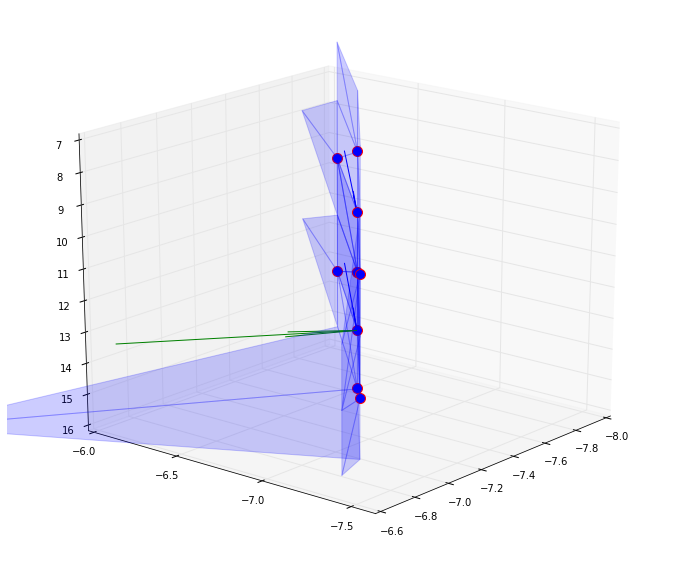

In [33]:
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')


for i in range(400,402):
    v = int(list(dedup_vertices)[i])
    ring = get_vertices_from_faces(v)
    faces = set()

    for i in ring + [v]:
        i = int(i)
        ax.scatter(tet_mesh.points[i][0], tet_mesh.points[i][1], tet_mesh.points[i][2], color="red", s=100)
        neigh = surrounding_faces[i]
        for ind, f in neigh:
            faces.add(tuple(f))

    maxc = max_curv[i]
    minc = min_curv[i]
    ax.quiver(tet_mesh.points[v][0], tet_mesh.points[v][1], tet_mesh.points[v][2], maxc[0], maxc[1], maxc[2], color="green")
    ax.quiver(tet_mesh.points[v][0], tet_mesh.points[v][1], tet_mesh.points[v][2], minc[0], minc[1], minc[2])

    for face in faces:
        vtx = list(map(lambda i: tet_mesh.points[i], face))
        tri = a3.art3d.Poly3DCollection([vtx], alpha=0.2, color="blue")
        ax.add_collection3d(tri)

ax.view_init(200, 500)
plt.show()

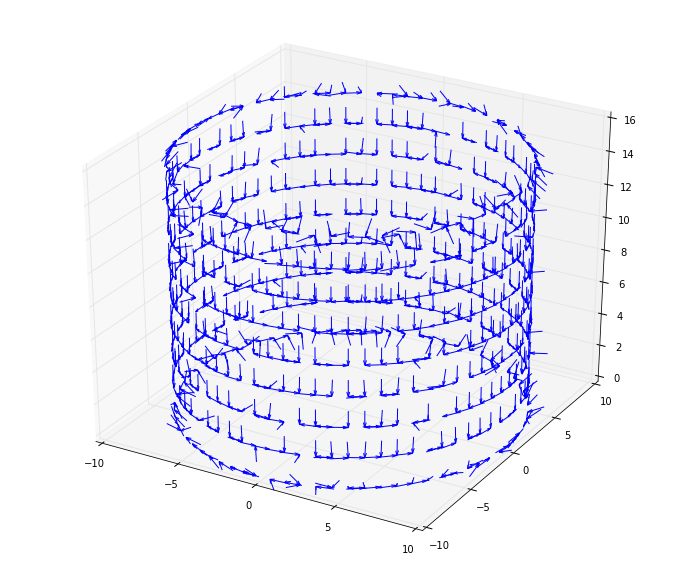

In [397]:
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

for i, v in enumerate(list(dedup_vertices)):
    i = int(i)
    v = int(v)
    maxc = [max_curv[i][0], max_curv[i][1], max_curv[i][2]]
    minc = [min_curv[i][0], min_curv[i][1], min_curv[i][2]]
    ax.quiver(tet_mesh.points[v][0], tet_mesh.points[v][1], tet_mesh.points[v][2], maxc[0], maxc[1], maxc[2])
    ax.quiver(tet_mesh.points[v][0], tet_mesh.points[v][1], tet_mesh.points[v][2], minc[0], minc[1], minc[2])


plt.show()

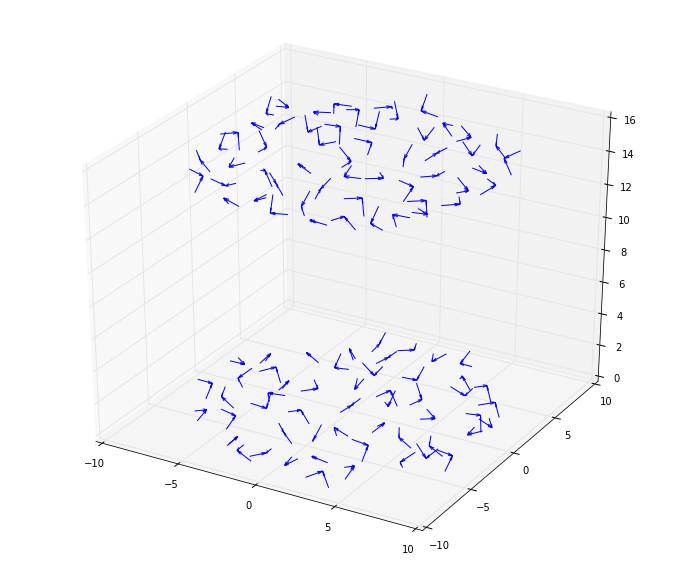

In [447]:
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

flat_vertices = [i for i, v in enumerate(dedup_vertices) if (max_curv[i] == np.zeros((3,))).all() and (min_curv[i] == np.zeros((3,))).all()]

for i, v in enumerate(list(dedup_vertices)[639:746]):
    i = int(i)
    v = int(v)
    c = "blue"
    if (max_curv[i] == np.zeros((3,))).all() and (min_curv[i] == np.zeros((3,))).all():
        c = "red"
    maxc = [max_curv[i][0], max_curv[i][1], max_curv[i][2]]
    minc = [min_curv[i][0], min_curv[i][1], min_curv[i][2]]
    ax.quiver(tet_mesh.points[v][0], tet_mesh.points[v][1], tet_mesh.points[v][2], maxc[0], maxc[1], maxc[2], color=c)
    ax.quiver(tet_mesh.points[v][0], tet_mesh.points[v][1], tet_mesh.points[v][2], minc[0], minc[1], minc[2], color=c)


plt.show()

In [385]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def drawmesh(alpha=0.9):
    for face in tet_mesh.faces:
        vtx = list(map(lambda i: tet_mesh.points[i], face))
        tri = a3.art3d.Poly3DCollection([vtx], alpha=alpha, color="white")
        ax.add_collection3d(tri)

### Propagate down the mesh

In [417]:
from scipy import spatial

data = vstack([tet_mesh.points[int(i)] for i in dedup_vertices])
tree = spatial.KDTree(data)

frame_field = []

surface_vertices = list(dedup_vertices)

for i, tet in enumerate(tet_mesh.elements):
    tet_center = vstack([tet_mesh.points[i] for i in tet]).mean(axis=0)
    distance, index = tree.query(tet_center)
    frame_field.append(Frame(max_curv[index].copy(), min_curv[index].copy(), v_norms[surface_vertices[index]].copy()))
    

In [363]:
from source.frame import Frame

# Initialize the surface tetrahedron with surface frame
bfs = []
frame_field = [Frame(np.zeros((3,)), np.zeros((3,)), np.zeros((3,))) for _ in range(len(tet_mesh.elements))]
avg_frame_field = [[Frame(np.zeros((3,)), np.zeros((3,)), np.zeros((3,))), 0] for _ in range(len(tet_mesh.elements))]
for i, tet in enumerate(tet_mesh.elements):
    neighbors = list(tet_mesh.neighbors[i])
    if -1 in neighbors:
        # Query closest surface face and assign
        tet_center = vstack([tet_mesh.points[i] for i in tet]).mean(axis=0)
        distance, index = tree.query(tet_center)
        frame_field[i].u = max_curv[index].copy()
        frame_field[i].v = min_curv[index].copy()
        frame_field[i].w = v_norms[surface_vertices[index]].copy()
        #
        avg_frame_field[i][0].u = max_curv[index].copy()
        avg_frame_field[i][0].v = min_curv[index].copy()
        avg_frame_field[i][0].w = v_norms[surface_vertices[index]].copy()
        avg_frame_field[i][1] = 1
        # Append to our Breath-first-search
        bfs.append(i)

# Propagate routine @TODO: Can be multihreaded
visited = set()
while bfs:
    i = bfs.pop()
    tet = tet_mesh.elements[i]
    neighbors = list(filter(lambda n: n not in visited, tet_mesh.neighbors[i]))
    for n in neighbors:
        frame_field[n] = frame_field[i]
        avg_frame_field[n][0].u += frame_field[i].u
        avg_frame_field[n][0].v += frame_field[i].v
        avg_frame_field[n][0].w += frame_field[i].w
        avg_frame_field[n][1] += 1
        bfs.append(n)
    visited.add(i)

def average_field(item):
    item[0].u /= item[1]
    item[0].v /= item[1]
    item[0].w /= item[1]
    return item[0]

avg_frame_field = list(map(average_field, avg_frame_field))

In [295]:
def face2edges(face):
    return [sorted([face[0], face[1]]),
            sorted([face[0], face[2]]),
            sorted([face[1], face[2]])]

# Get all edges
all_edges = tet_mesh.edges

# Extract edges from face indexing
surface_edges = np.concatenate(list(map(face2edges, surface_faces)))

# Make it hashable
surface_edges = map(lambda edge: tuple(edge), surface_edges)
surface_edges = set(surface_edges)

# Make it hashable
all_edges = set(map(lambda edge: tuple(sorted(edge)), all_edges))

# Remove surface to get internal
internal_edges = all_edges.difference(surface_edges)

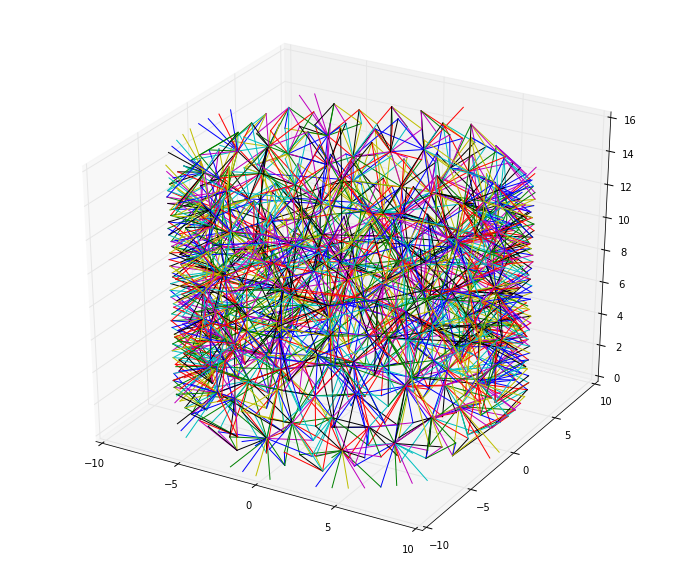

In [297]:
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

for i, j in list(internal_edges):
    i = int(i)
    j = int(j)
    ax.plot([tet_mesh.points[i][0], tet_mesh.points[j][0]],
            [tet_mesh.points[i][1], tet_mesh.points[j][1]],
            [tet_mesh.points[i][2], tet_mesh.points[j][2]])


    
plt.show()

In [305]:
# Tetrahedron sharing an edge
def has_edge(edge, ind_tet_tuple):
    return edge[0] in ind_tet_tuple[1] and edge[1] in ind_tet_tuple[1]

edge_neighbours = []
for edge in internal_edges:
    edge_neighbours.append(list(filter(lambda tet: has_edge(edge, tet), zip(range(len(tet_mesh.elements)), tet_mesh.elements))))

In [418]:
import hashlib
from numpy import transpose
from collections import defaultdict

matching = {}
for pind, p in enumerate(rotational_projections):
    for i, t in enumerate(tet_mesh.elements):
        for n in tet_mesh.neighbors[i]:
            s = frame_field[i]
            t = frame_field[n]
            key = hash(tuple(sorted((i, n))))
            match = np.matrix([s.u, s.v, s.w]) - np.matrix([t.u, t.v, t.w]) * transpose(p)
            arg = norm(match)
            if key in matching:
                if arg < matching[key][0]:
                    matching[key] = (arg, pind, match)
            else:
                matching[key] = (arg, pind, match)

In [400]:
import itertools

for edge_id, edge in enumerate(internal_edges):
    cum = None
    adjacent_tets = list(map(lambda item: item[0], edge_neighbours[edge_id]))
    key_pairs = [hash(tuple(sorted((i, j)))) for i, j in itertools.product(adjacent_tets, adjacent_tets)]
    for key in key_pairs:
        # If they are adjacent tetrahedron
        if key in matching:
            if cum is not None:
                cum = np.concatenate(cum, matching[key][2])
            else:
                cum = matching[key][2]
    print(cum)

TypeError: only length-1 arrays can be converted to Python scalars

In [403]:
matching[key][2]

matrix([[ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [  0.,   0.,   0.]])

### Oxtahedron Symmetry Group

In [157]:
'''
Regular Octahedron

The twelve matrices are those matrices with their (+/-) 1's 
in the following three positions :

    1 - -    - 1 -    - - 1
    - 1 -    - - 1    1 - -
    - - 1    1 - -    - 1 -

And either three or one of these 1's carried a "+" sign.

It will be found that the remaining twelve matrices which 
complete the full group of the Tetrahedron (or the group of 
direct symmetries of the Cube or Regular Octahedron), will 
have their (+/-) 1's in the three remaining possible positions

    - - 1    - 1 -    1 - -
    - 1 -    1 - -    - - 1
    1 - -    - - 1    - 1 -

http://home.kpn.nl/turing/d3_lattice_13.html
'''
reflective_projections = [
    np.matrix([[ 1,  0,  0], [ 0,  1,  0], [ 0,  0,  1]]),
    np.matrix([[ 1,  0,  0], [ 0, -1,  0], [ 0,  0, -1]]),
    np.matrix([[-1,  0,  0], [ 0,  1,  0], [ 0,  0, -1]]),
    np.matrix([[-1,  0,  0], [ 0, -1,  0], [ 0,  0,  1]]),
    
    np.matrix([[ 0,  1,  0], [ 0,  0,  1], [ 1,  0,  0]]),
    np.matrix([[ 0,  0,  1], [ 1,  0,  0], [ 0,  1,  0]]),
    np.matrix([[ 0,  0,  1], [-1,  0,  0], [ 0, -1,  0]]),
    np.matrix([[ 0, -1,  0], [ 0,  0, -1], [ 1,  0,  0]]),

    np.matrix([[ 0,  1,  0], [ 0,  0, -1], [-1,  0,  0]]),
    np.matrix([[ 0,  0, -1], [ 1,  0,  0], [ 0, -1,  1]]),
    np.matrix([[ 0,  0, -1], [-1,  0,  0], [ 0,  1,  0]]),
    np.matrix([[ 0, -1,  0], [ 0,  0,  1], [-1,  0,  0]]),

    np.matrix([[ 0,  0,  1], [ 0,  1,  0], [ 1,  0,  0]]),
    np.matrix([[ 0,  0,  1], [ 0, -1,  0], [-1,  0,  0]]),
    np.matrix([[ 0,  0, -1], [ 0,  1,  0], [-1,  0,  0]]),
    np.matrix([[ 0,  0, -1], [ 0, -1,  0], [ 1,  0,  0]]),

    np.matrix([[ 0,  1,  0], [ 1,  0,  0], [ 0,  0,  1]]),
    np.matrix([[ 0,  1,  0], [-1,  0,  0], [ 0,  0, -1]]),
    np.matrix([[ 0, -1,  0], [ 1,  0,  0], [ 0,  0, -1]]),
    np.matrix([[ 0, -1,  0], [-1,  0,  0], [ 0,  0,  1]]),

    np.matrix([[ 1,  0,  0], [ 0,  0,  1], [ 0,  1,  0]]),
    np.matrix([[ 1,  0,  0], [ 0,  0, -1], [ 0, -1,  0]]),
    np.matrix([[-1,  0,  0], [ 0,  0,  1], [ 0, -1,  0]]),
    np.matrix([[-1,  0,  0], [ 0,  0, -1], [ 0,  1,  0]]),
]

rotational_projections = [
    np.matrix([[ 1,  0,  0], [ 0,  1,  0], [ 0,  0,  1]]),
    np.matrix([[-1,  0,  0], [ 0,  1,  0], [ 0,  0,  1]]),
    np.matrix([[ 1,  0,  0], [ 0, -1,  0], [ 0,  0,  1]]),
    np.matrix([[ 1,  0,  0], [ 0,  1,  0], [ 0,  0, -1]]),
    
    np.matrix([[ 0,  1,  0], [ 0,  0,  1], [ 1,  0,  0]]),
    np.matrix([[ 0, -1,  0], [ 0,  0,  1], [ 1,  0,  0]]),
    np.matrix([[ 0,  1,  0], [ 0,  0, -1], [ 1,  0,  0]]),
    np.matrix([[ 0,  1,  0], [ 0,  0,  1], [-1,  0,  0]]),

    np.matrix([[ 0,  0,  1], [ 1,  0,  0], [ 0,  1,  0]]),
    np.matrix([[ 0,  0, -1], [ 1,  0,  0], [ 0,  1,  0]]),
    np.matrix([[ 0,  0,  1], [-1,  0,  0], [ 0,  1,  0]]),
    np.matrix([[ 0,  0,  1], [ 1,  0,  0], [ 0, -1,  0]]),

    np.matrix([[ 0,  0,  1], [ 0,  1,  0], [ 1,  0,  0]]),
    np.matrix([[ 0,  0, -1], [ 0,  1,  0], [ 1,  0,  0]]),
    np.matrix([[ 0,  0,  1], [ 0, -1,  0], [ 1,  0,  0]]),
    np.matrix([[ 0,  0,  1], [ 0,  1,  0], [-1,  0,  0]]),

    np.matrix([[ 0,  1,  0], [ 1,  0,  0], [ 0,  0,  1]]),
    np.matrix([[ 0, -1,  0], [ 1,  0,  0], [ 0,  0,  1]]),
    np.matrix([[ 0,  1,  0], [-1,  0,  0], [ 0,  0,  1]]),
    np.matrix([[ 0,  1,  0], [ 1,  0,  0], [ 0,  0, -1]]),

    np.matrix([[ 1,  0,  0], [ 0,  0,  1], [ 0,  1,  0]]),
    np.matrix([[-1,  0,  0], [ 0,  0,  1], [ 0,  1,  0]]),
    np.matrix([[ 1,  0,  0], [ 0,  0, -1], [ 0,  1,  0]]),
    np.matrix([[ 1,  0,  0], [ 0,  0,  1], [ 0, -1,  0]]),
]